In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from chemotools.derivative import SavitzkyGolay
from chemotools.scatter import StandardNormalVariate
from chemotools.feature_selection import RangeCut
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression
import seaborn as sns

In [3]:
# Load the spectra data
df = pd.read_csv("../data/combined_data.csv")
df.head()

,397.66,400.28,402.9,405.52,408.13,410.75,413.37,416,418.62,421.24,...,981.27,984.09,986.9,989.72,992.54,995.35,998.17,1000.99,1003.81,class
0,0.160989,0.152837,0.143099,0.132230,0.121732,0.113088,0.106684,0.102206,0.097464,0.094226,...,0.268508,0.268674,0.268942,0.269235,0.269651,0.270141,0.270695,0.271260,0.271902,canola
1,0.157316,0.148315,0.139275,0.129330,0.120090,0.112003,0.105155,0.100885,0.097040,0.093725,...,0.277404,0.277630,0.277895,0.278252,0.278681,0.279293,0.279852,0.280512,0.281131,canola
2,0.180705,0.171157,0.159826,0.147212,0.136382,0.126773,0.119723,0.115086,0.109832,0.105594,...,0.304266,0.304477,0.304762,0.305169,0.305732,0.306397,0.307044,0.307668,0.308387,canola
3,0.159618,0.151638,0.141948,0.131743,0.121592,0.112819,0.106271,0.101794,0.097496,0.094452,...,0.270041,0.270336,0.270555,0.270984,0.271544,0.272093,0.272727,0.273407,0.274073,canola
4,0.147031,0.139998,0.130906,0.121395,0.112400,0.104592,0.098618,0.095303,0.091420,0.088122,...,0.247827,0.248123,0.248419,0.248833,0.249397,0.249951,0.250570,0.251253,0.251939,canola


In [4]:
#Explore 

print(f"The spectra dataset has {df.shape[0]} samples") 
print(f"The spectra dataset has {df.shape[1]} features") 

The spectra dataset has 160 samples
The spectra dataset has 225 features


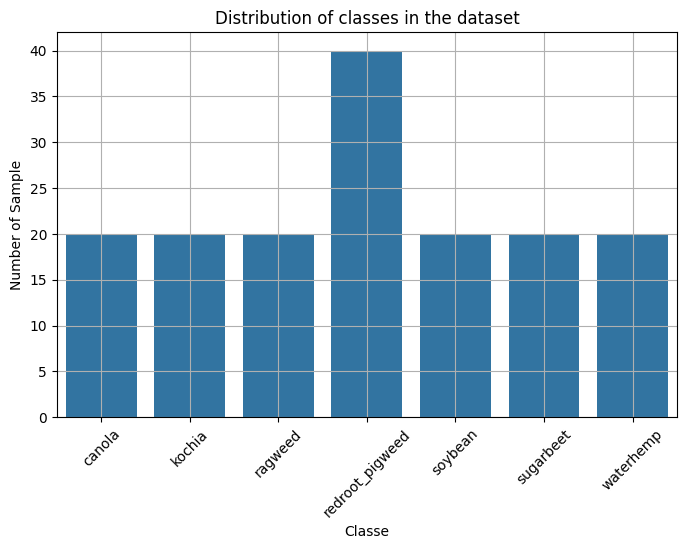

In [5]:
# X = spectral columns (all except 'class')
X = df.drop(columns=["class"])

# y = labels (plant names)
y = df["class"]

#plot the sample sizes


plt.figure(figsize=(8, 5))
sns.countplot(x=y)  # x=y_encoded if you use encoded labels
plt.title("Distribution of classes in the dataset")
plt.xlabel("Classe")
plt.ylabel("Number of Sample")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


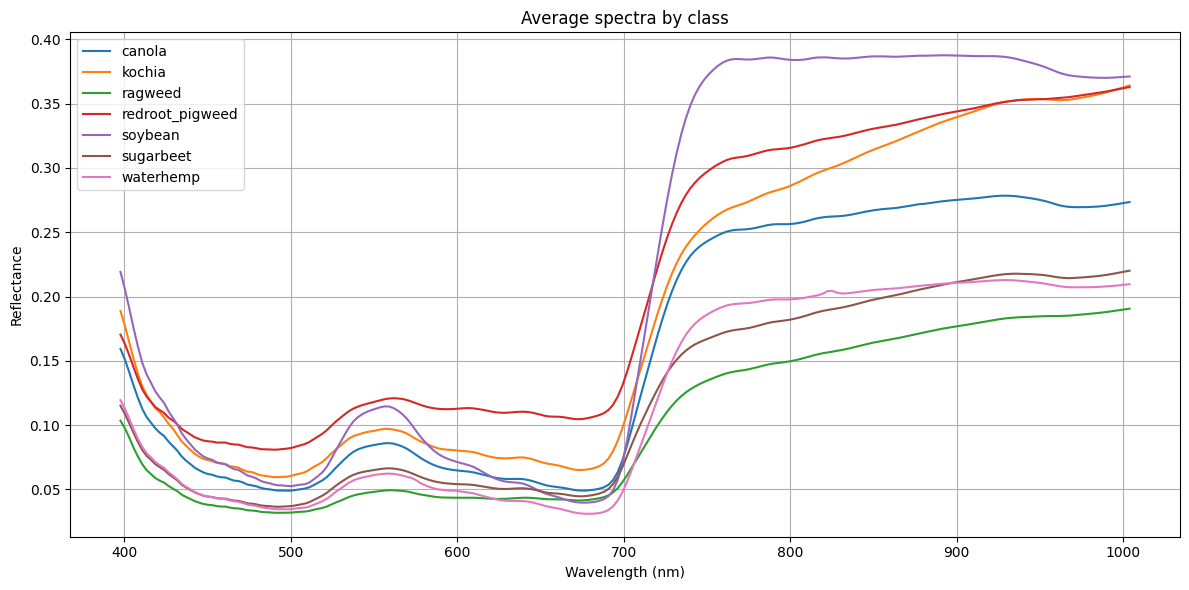

In [6]:
# Converting wavelengths to float for plotting
wavelengths = X.columns.astype(float)



plt.figure(figsize=(12, 6))

# Plot an average spectrum per class
for label in y.unique():
    mean_spectrum = X[y == label].mean()
    plt.plot(wavelengths, mean_spectrum, label=label)

plt.title("Average spectra by class")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

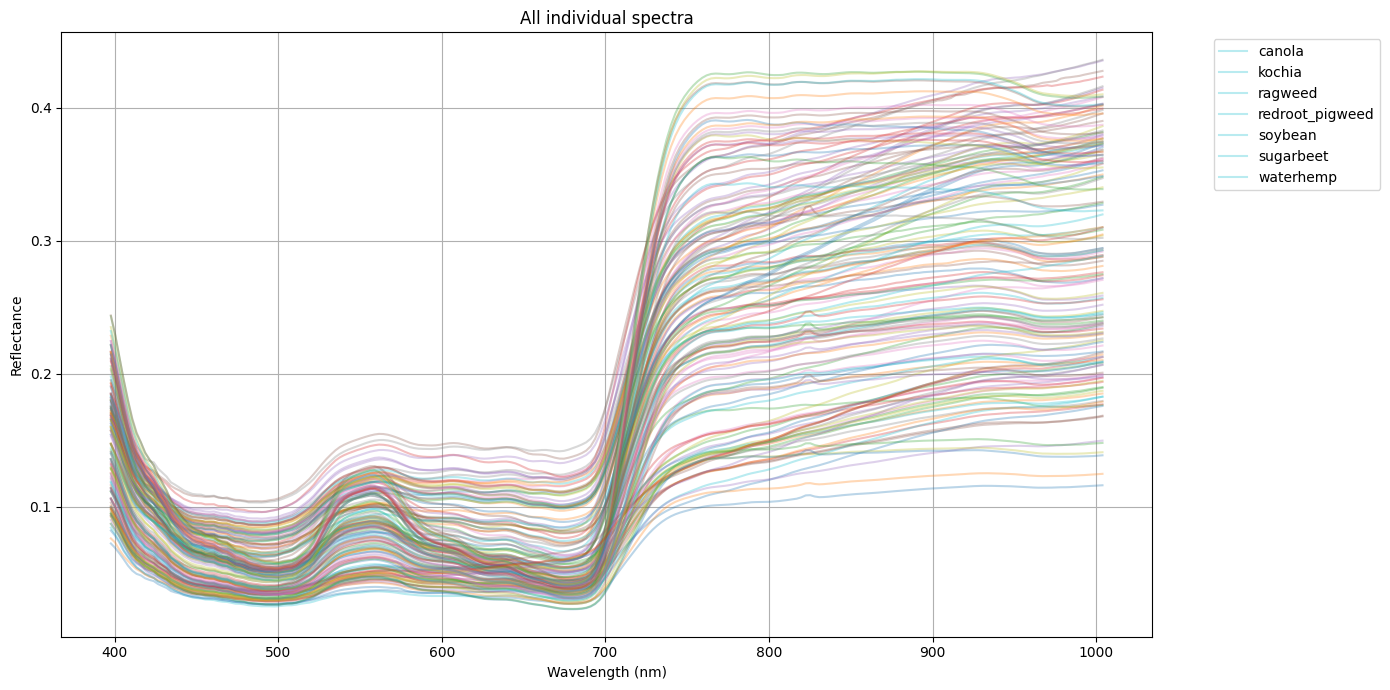

In [7]:
plt.figure(figsize=(14, 7))

# For each sample, plot its spectrum with a color corresponding to its class
for i in range(len(X)):
    plt.plot(wavelengths, X.iloc[i], alpha=0.3, label=y.iloc[i])

# To avoid thousands of duplicates in the legend, we display each class only once
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("All individual spectra")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Reflectance")
plt.grid(True)
plt.tight_layout()
plt.show()



In [13]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(y_encoded)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6]


In [9]:
# Make a OneHotEncoder object 
enc = OneHotEncoder(handle_unknown='ignore')
# Fit the LabelEncoder object 
enc.fit(df.values)
# Transform the labels 
y_dummy = enc.transform(df.values).toarray()
print(y_dummy)
print(enc.inverse_transform(y_dummy))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]
[[0.160989132 0.152836663 0.143099078 ... 0.271259835 0.271902189
  'canola']
 [0.157316209 0.148314573 0.139275196 ... 0.280511568 0.281131344
  'canola']
 [0.18070481 0.171156991 0.159826499 ... 0.307668081 0.308387158 'canola']
 ...
 [0.135983499 0.128599791 0.118909993 ... 0.237805411 0.238209198
  'waterhemp']
 [0.129569268 0.122876851 0.114053387 ... 0.231181649 0.231554541
  'waterhemp']
 [0.140107551 0.132850176 0.123270376 ... 0.244579954 0.244879224
  'waterhemp']]


In [ ]:
import numpy as np

# 📌 SNV function applied line by line
def apply_snv(X_df):
    X_array = X_df.values
    snv_array = (X_array - X_array.mean(axis=1, keepdims=True)) / X_array.std(axis=1, keepdims=True)
    return pd.DataFrame(snv_array, columns=X_df.columns, index=X_df.index)

# 🔁 Application
X_snv = apply_snv(X)

from scipy.signal import savgol_filter

# 📌 Savitzky-Golay smoothing function
def apply_savgol(X_df, window_length=15, polyorder=2):
    smoothed_array = savgol_filter(X_df.values, window_length=window_length, polyorder=polyorder, axis=1)
    return pd.DataFrame(smoothed_array, columns=X_df.columns, index=X_df.index)

# 🔁 Application of smoothing on SNV spectra
X_snv_smooth = apply_savgol(X_snv, window_length=15, polyorder=2)

# 📌 Savitzky-Golay derivative function
def apply_savgol_derivative(X_df, window_length=15, polyorder=2, deriv=1):
    derived_array = savgol_filter(X_df.values, window_length=window_length, polyorder=polyorder, deriv=deriv, axis=1)
    return pd.DataFrame(derived_array, columns=X_df.columns, index=X_df.index)

# 🔁 Application : SNV + smoothing + derivative 1
X_preprocessed = apply_savgol_derivative(X_snv_smooth, window_length=15, polyorder=2, deriv=1)

# 🔁 Application : SNV + lissage + derivative 2
X_preprocessed_d2 = apply_savgol_derivative(X_snv_smooth, window_length=15, polyorder=2, deriv=2)

In [26]:
# Separate the train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Display the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Testing multiple numbers of PLS ​​components
component_range = list(range(2, 30))
scores = []

X_train shape: (128, 224)
X_test shape: (32, 224)
y_train shape: (128,)
y_test shape: (32,)


In [15]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score

# Loop through the range of components and calculate cross-validation scores
for n in component_range:
    pls = PLSRegression(n_components=n)
    X_train_pls = pls.fit_transform(X_train_scaled, y_train)[0]
    clf = RandomForestClassifier(random_state=42)
    cv_score = cross_val_score(clf, X_train_pls, y_train, cv=5, scoring='accuracy').mean()
    scores.append(cv_score)

In [18]:
# The best choice 
best_n = component_range[np.argmax(scores)]
print(f"\nOptimal number of PLS ​​components : {best_n}")

# Final training with this number of components
pls_final = PLSRegression(n_components=best_n)
X_train_pls_final = pls_final.fit_transform(X_train_scaled, y_train)[0]
X_test_pls_final = pls_final.transform(X_test_scaled)


Optimal number of PLS ​​components : 12


In [19]:
clf_final = RandomForestClassifier(random_state=42)
clf_final.fit(X_train_pls_final, y_train)
y_pred = clf_final.predict(X_test_pls_final)

# Result
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Accuracy test : {accuracy_score(y_test, y_pred):.2f}")


Classification Report:
                 precision    recall  f1-score   support

         canola       1.00      1.00      1.00         4
         kochia       1.00      1.00      1.00         4
        ragweed       1.00      1.00      1.00         4
redroot_pigweed       1.00      1.00      1.00         8
        soybean       1.00      1.00      1.00         4
      sugarbeet       1.00      1.00      1.00         4
      waterhemp       1.00      1.00      1.00         4

       accuracy                           1.00        32
      macro avg       1.00      1.00      1.00        32
   weighted avg       1.00      1.00      1.00        32

Accuracy test : 1.00


<Figure size 1400x1000 with 0 Axes>

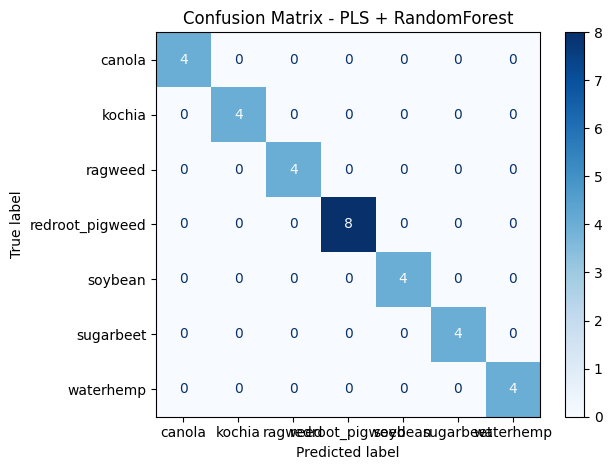

In [24]:
# Confusion matrix
plt.figure(figsize=(14, 10))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=label_encoder.classes_, cmap='Blues'
)
plt.title("Confusion Matrix - PLS + RandomForest")
plt.tight_layout()
plt.show()